In [2]:
# --- Now, a concrete implementation using ASE ---
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.calculators.lj import LennardJones
calc = LennardJones(sigma=1, epsilon=1, rc=3, smooth=False)

def lj2(r):
    atoms = Atoms('X2', [[0,0,0],[r,0,0]])
    atoms.calc = calc
    return atoms.get_total_energy(), atoms.get_forces()

In [3]:
lj2(3)[1].flatten()

array([ 0.01094383,  0.        ,  0.        , -0.01094383,  0.        ,
        0.        ])

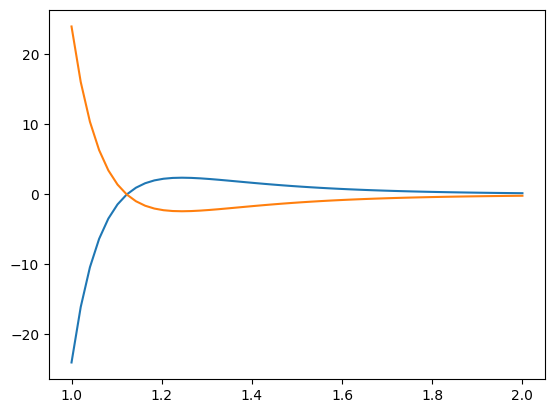

In [4]:
x = np.linspace(1,2)
y = np.array([np.dot(lj2(val)[1], [1,0,0]) for val in x])
plt.plot(x,y)

In [5]:
# Test with LJ cluster
from optimizers import ScipyOptimizer, ASEOptimizer
from potentials import LennardJonesCluster
from ca_abc import CurvatureAdaptiveABC
import numpy as np

np.random.seed(42)

mypot = LennardJonesCluster(2)
myabc = CurvatureAdaptiveABC(mypot)

# Add more robust configuration
myopt = ScipyOptimizer(myabc, method="L-BFGS-B")
myopt=ASEOptimizer(myabc, 'FIRE')

# Ensure proper starting position
x0 = mypot.default_starting_position().astype(np.float64)

# Run with safeguards
result = myopt.descend(x0, max_steps=100, convergence_threshold=1e-5)
print(result)

      Step     Time          Energy          fmax
FIRE:    0 12:49:18       -0.240766        0.872763
FIRE:    1 12:49:18       -0.256526        0.933731
FIRE:    2 12:49:18       -0.292728        1.073304
FIRE:    3 12:49:18       -0.361858        1.335519
FIRE:    4 12:49:18       -0.493506        1.801028
FIRE:    5 12:49:18       -0.750017        2.385177
FIRE:    6 12:49:18       -0.956391        2.570480
FIRE:    7 12:49:18       -0.981511        1.383130
FIRE:    8 12:49:18       -0.994519        0.014738
FIRE:    9 12:49:18       -0.984803        0.933712
FIRE:   10 12:49:18       -0.985865        0.887501
FIRE:   11 12:49:18       -0.987781        0.794213
FIRE:   12 12:49:18       -0.990148        0.652691
FIRE:   13 12:49:18       -0.992431        0.462680
FIRE:   14 12:49:18       -0.994047        0.226715
FIRE:   15 12:49:18       -0.994501        0.047454
FIRE:   16 12:49:18       -0.994502        0.046593
FIRE:   17 12:49:18       -0.994503        0.044889
FIRE:   18 12:

In [6]:
from ca_abc import CurvatureAdaptiveABC
from potentials import *
from optimizers import *
mypot = Complex1D()
mypot = StandardMullerBrown2D()
myabc = CurvatureAdaptiveABC(mypot)

myopt = ScipyOptimizer(myabc, method="BFGS")


result = myopt.descend([0, 0], 20, 1e-5)
result

remove_rotation_translation=True is incompatible with potentials without 3N cartesian dimensions; setting to False.


({'x': array([0.62349941, 0.02803776]),
  'converged': True,
  'nit': 7,
  'message': 'Optimization terminated successfully.',
  'hess_inv': array([[ 1.83919501e-03, -9.14731203e-05],
         [-9.14731203e-05,  3.40357931e-04]])},
 {'trajectory': [array([0., 0.]),
   array([0.23007699, 0.20781567]),
   array([0.59616943, 0.03292627]),
   array([0.61459307, 0.02528581]),
   array([0.62263251, 0.02840701]),
   array([0.62354634, 0.02801991]),
   array([0.6234993 , 0.02803778])],
  'unbiased_energies': [np.float64(-48.40127417318389),
   np.float64(-74.76537570406889),
   np.float64(-107.95138334722715),
   np.float64(-108.12988163425165),
   np.float64(-108.1663619034848),
   np.float64(-108.16672315956717),
   np.float64(-108.16672411684873)],
  'biased_energies': [np.float64(-48.40127417318389),
   np.float64(-74.76537570406889),
   np.float64(-107.95138334722715),
   np.float64(-108.12988163425165),
   np.float64(-108.1663619034848),
   np.float64(-108.16672315956717),
   np.float64(

In [7]:
from potentials import *
from optimizers import *

from scipy.optimize import minimize
import numpy as np

mypot = StandardMullerBrown2D().potential
mygrad = StandardMullerBrown2D().gradient

options = {'gtol':1e-5}

minimize(fun=mypot, x0=(0,0), 
         jac=lambda x: mygrad(x), 
         method="BFGS", options=options)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -108.16672411685238
        x: [ 6.235e-01  2.804e-02]
      nit: 7
      jac: [ 1.225e-07  3.413e-07]
 hess_inv: [[ 1.839e-03 -9.147e-05]
            [-9.147e-05  3.404e-04]]
     nfev: 13
     njev: 13

In [8]:
from ca_abc import CurvatureAdaptiveABC
myabc = CurvatureAdaptiveABC(StandardMullerBrown2D())
myopt = ScipyOptimizer(myabc, method="BFGS")

myopt.descend(np.array([0,0]), convergence_threshold=1e-5)

remove_rotation_translation=True is incompatible with potentials without 3N cartesian dimensions; setting to False.


({'x': array([0.62349941, 0.02803776]),
  'converged': True,
  'nit': 7,
  'message': 'Optimization terminated successfully.',
  'hess_inv': array([[ 1.83919501e-03, -9.14731203e-05],
         [-9.14731203e-05,  3.40357931e-04]])},
 {'trajectory': [array([0., 0.]),
   array([0.23007699, 0.20781567]),
   array([0.59616943, 0.03292627]),
   array([0.61459307, 0.02528581]),
   array([0.62263251, 0.02840701]),
   array([0.62354634, 0.02801991]),
   array([0.6234993 , 0.02803778])],
  'unbiased_energies': [np.float64(-48.40127417318389),
   np.float64(-74.76537570406889),
   np.float64(-107.95138334722715),
   np.float64(-108.12988163425165),
   np.float64(-108.1663619034848),
   np.float64(-108.16672315956717),
   np.float64(-108.16672411684873)],
  'biased_energies': [np.float64(-48.40127417318389),
   np.float64(-74.76537570406889),
   np.float64(-107.95138334722715),
   np.float64(-108.12988163425165),
   np.float64(-108.1663619034848),
   np.float64(-108.16672315956717),
   np.float64(

In [9]:
from potentials import *
from optimizers import *

from scipy.optimize import minimize
import numpy as np

myabc = CurvatureAdaptiveABC(StandardMullerBrown2D())

options = {'gtol':1e-5}

minimize(fun=myabc.compute_biased_potential, x0=(0,0), 
         jac=lambda x: -myabc.compute_biased_force(x), 
         method="BFGS", options=options)

remove_rotation_translation=True is incompatible with potentials without 3N cartesian dimensions; setting to False.


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -108.16672411685238
        x: [ 6.235e-01  2.804e-02]
      nit: 7
      jac: [ 1.225e-07  3.413e-07]
 hess_inv: [[ 1.839e-03 -9.147e-05]
            [-9.147e-05  3.404e-04]]
     nfev: 13
     njev: 13

In [10]:
def compare(x):
    print("F:", myabc.compute_biased_force(x))
    print("G:", myabc.potential.gradient(x))

compare([0.5,0])

F: [60.37814423 93.59093663]
G: [-60.37814423 -93.59093663]
